## **Chapter 8: Forecasting (Time Series Analysis)**

**Import and Prepare the Data**

In [4]:
!pip install statsmodels --upgrade

In [5]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Use this to suppress scientific notation

df = pd.read_csv('walmart_sales.csv')
df.sort_values(by=['Date'], inplace=True)
print(df.dtypes)
df.head()

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
5208,37,01-04-2011,534578.780,0,67.310,3.524,213.578,8.300
1204,9,01-04-2011,520962.140,0,56.120,3.524,218.445,6.380
1776,13,01-04-2011,1864238.640,0,42.490,3.487,128.720,7.193
2634,19,01-04-2011,1305950.220,0,30.680,3.811,134.068,7.658
6066,43,01-04-2011,611585.540,0,67.790,3.524,206.673,10.581


**Change the Date types**: The above dataset has dates, but they are stored as *strings*. In order to do time series and work with autocorrelation, change the Date column to *date* datatypes. 

In [6]:
df.Date = pd.to_datetime(df.Date)
df.dtypes

ValueError: time data "13-01-2012" doesn't match format "%m-%d-%Y", at position 57. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

**Combine days into months**: For convenience, the author decides to combine the data into months. This is *your choice* as the analyst whether this will be useful or not. 

In [ ]:
df.index = pd.DatetimeIndex(df.Date).to_period('M')
df_agg = df.groupby(pd.Grouper(freq="M")).agg({'Weekly_Sales':'sum',
                                               'Holiday_Flag':'mean',
                                               'Temperature':'mean',
                                               'Fuel_Price':'mean',
                                               'CPI':'mean',
                                               'Unemployment':'mean'})
df_agg.tail()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2012-08,191612586.860,0.000,75.953,3.735,175.773,7.283
2012-09,179795939.270,0.000,63.617,3.842,175.945,7.305
2012-10,188079385.820,0.250,60.796,3.701,175.886,7.163
2012-11,46925878.990,0.000,64.838,3.870,175.626,7.420
2012-12,46128514.250,0.000,58.343,3.897,176.637,6.954


**Weekly Sales**: Ultimately, we are searching for *trends* in the weekly sales based on time (such as *seasons*)

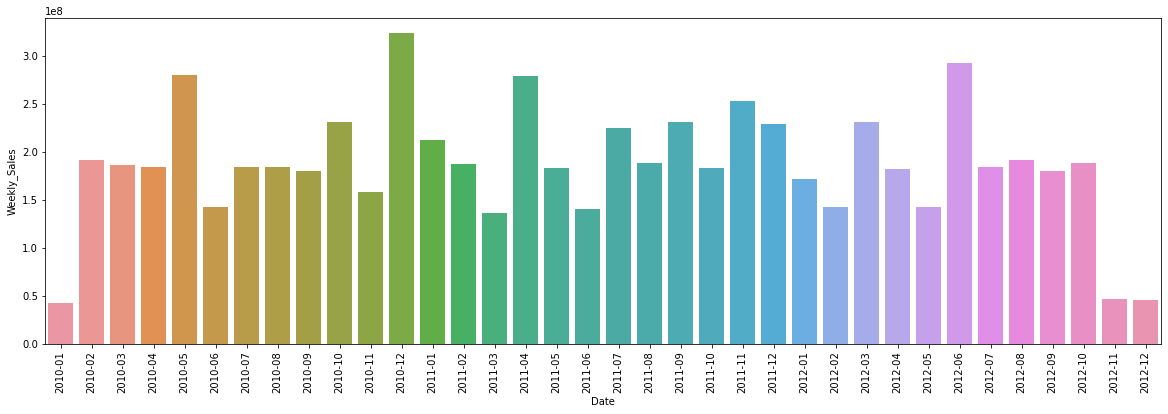

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
sns.barplot(x=df_agg.index, y="Weekly_Sales", data=df_agg, ax=ax)
plt.xticks(rotation=90)
plt.show()

**Line Plot**: For searching for trends over time or seasons, a line plot is probably better.

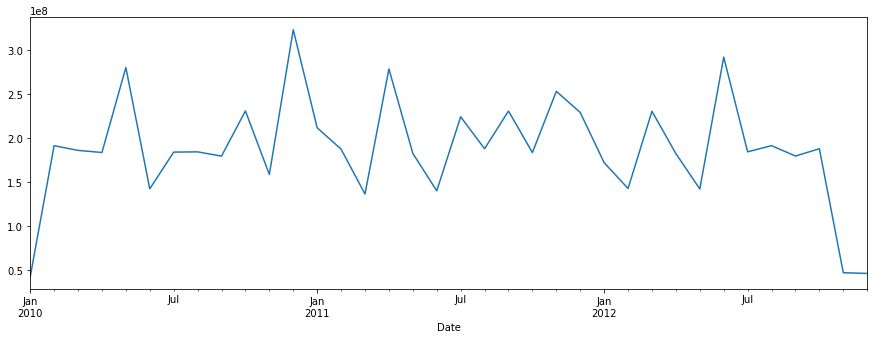

In [ ]:
df_agg.Weekly_Sales.plot(figsize=(15,5));

## **Stationarity and Lag**
After cleaning the preparing the data as well as visualizing, we begin the process of determining which algorithm is most appropriate. To do so, proceed next by checking the **stationarity** (the degree to which the statistical properties [mean, variance, autocorrelation] are *consistent* over time. Do this using the **Augmented Dickey-Fuller test**. If the test returns a **p-value <= 0.05**, then you have **sufficient stationarity** to proceed with a basic autogregressive algorithm based on linear regression.

**Augmented Dickey-Fuller Test:** *Testing for stationarity, which is what you want to go forward. A low p-value indicates stationarity*

*Example*: If your data is slowly moving up over time year after year, then the data would NOT be stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

stationarity = adfuller(df_agg['Weekly_Sales'], autolag='AIC')
print("P-value: ", stationarity[1])

# Is our dataset stationary?

P-value:  6.829321051914046e-07


**TV Sales**: What do we do when our data is NOT stationary?

In [ ]:
df_tv = pd.read_csv('tv_sales.csv')
df_tv.sort_values(by=['Date'], inplace=True)
df_tv.head()

,Date,Model,Count
45585,01-Apr-14,M119,12
45586,01-Apr-14,M54,36
45587,01-Apr-14,M33,50
45588,01-Apr-14,M58,52
45589,01-Apr-14,M75,1


We want to predict the *count* of TV sales, after aggregating by month and converting the Date column to a date datatype. Then we test for stationarity.

In [ ]:
df_tv.Date = pd.to_datetime(df_tv.Date)
df_tv.index = pd.DatetimeIndex(df_tv.Date).to_period('D')
df_tv = df_tv.groupby(pd.Grouper(freq="M")).agg({'Count':'count'})
stationarity = adfuller(df_tv['Count'], autolag='AIC')
print("P-value: ", stationarity[1])

P-value:  0.9317731864300911


In [ ]:
stationarity # just to see the raw data

(-0.25398603658678837,
 0.9317731864300911,
 0,
 31,
 {'1%': -3.661428725118324,
  '5%': -2.960525341210433,
  '10%': -2.6193188033298647},
 258.39574735212653)

**Differencing**: The easiest and quickest way of fixing non-stationarity is by taking the *difference* of each datapoint and its previous datapoint... or previous two datapoints. (In other words, February minus January sales, then March - February sales, etc.)

*But how do you choose whether to take the difference of one datapoint from another, two datapoints, or more?*

In [ ]:
df_tv['Count_diff_1'] = df_tv['Count'].diff(periods=1)
df_tv['Count_diff_2'] = df_tv['Count'].diff(periods=2)
df_tv.head()

,Count,Count_diff_1,Count_diff_2
Date,,,
2014-01,98,NaN,NaN
2014-02,191,93.000,NaN
2014-03,233,42.000,135.000
2014-04,309,76.000,118.000
2014-05,437,128.000,204.000


**THE STATIONARITY IS FIXED!!**

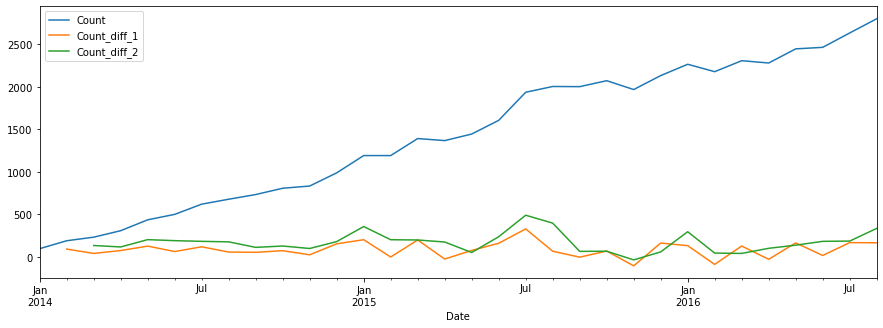

In [ ]:
df_tv.plot(figsize=(15,5));

**Wow, even the p-values look better, but only for the one month differencing**

In [ ]:
stationarity = adfuller(df_tv['Count_diff_1'].dropna(), autolag='AIC')
print("P-value of first-order diff:\t", stationarity[1])

stationarity = adfuller(df_tv['Count_diff_2'].dropna(), autolag='AIC')
print("P-value of second-order diff:\t", stationarity[1])

P-value of first-order diff:	 8.970106449403325e-09
P-value of second-order diff:	 0.09344020998849384


**ACF Plot**: Use the following plot to figuring out terms for **Moving Average (MA)**. Look for dots or patterns OUTSIDE of the blue area.

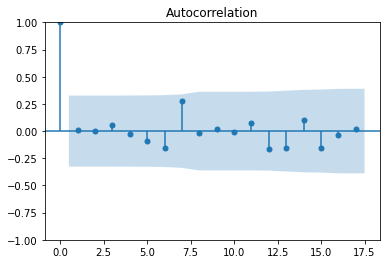

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(df_agg['Weekly_Sales'], lags=17)

**PACF Plot**: Use the following plot to figuring out terms for **Autoregression (AR)**. Look for dots or patterns OUTSIDE of the blue area.

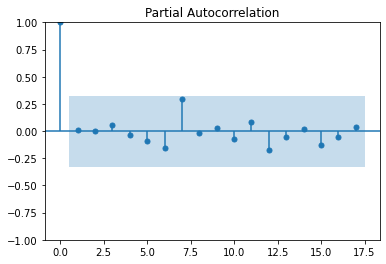

In [ ]:
pacf = plot_pacf(df_agg['Weekly_Sales'], lags=17, method='ywm')

## **Moving Average (MA)**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the model; order=(0, 0, 1) means it is a first order model
model = ARIMA(df_agg.Weekly_Sales, order=(0, 0, 1)) # We will learn more about order= in the next algorithms
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                   36
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -696.375
Date:                Fri, 11 Feb 2022   AIC                           1398.749
Time:                        18:02:06   BIC                           1403.500
Sample:                    01-31-2010   HQIC                          1400.407
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.871e+08    1.3e-09   1.44e+17      0.000    1.87e+08    1.87e+08
ma.L1          0.0161      0.159      0.101      0.919      -0.295       0.328
sigma2      3.509e+15   9.05e-18   3.88e+32      0.0

In [ ]:
# make and predictions
forecast_ma = model.predict(len(df_agg), len(df_agg) + 6)
print(forecast_ma)

2013-01   184912882.536
2013-02   187144971.864
2013-03   187144971.864
2013-04   187144971.864
2013-05   187144971.864
2013-06   187144971.864
2013-07   187144971.864
Freq: M, Name: predicted_mean, dtype: float64


In [ ]:
df_fit = pd.DataFrame(columns=['AIC', 'BIC', 'Model'])
df_fit.set_index('Model', inplace=True)

df_fit.loc["Moving Average"] = [round(model.aic, 2), round(model.bic, 2)]
df_fit

,AIC,BIC
Model,,
Moving Average,1398.750,1403.500


## **Autoregressive AR-X(p) model**

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

# fit model
model = AutoReg(df_agg.Weekly_Sales, lags=[1], trend='ct', seasonal=False)
model = model.fit()

# make predictions
forecast_autoreg = model.predict(len(df_agg), len(df_agg) + 6)
print(forecast_autoreg, '\n')

# fit statistics to DataFrame
df_fit.loc["AutoReg"] = [round(model.aic, 2), round(model.bic, 2)]
df_fit

2013-01   163234251.607
2013-02   162290024.835
2013-03   160766549.719
2013-04   159240232.343
2013-05   157713901.021
2013-06   156187569.630
2013-07   154661238.239
Freq: M, dtype: float64 



,AIC,BIC
Model,,
Moving Average,1398.750,1403.500
AutoReg,1354.140,1360.360


## **Autogregressive Moving Average (ARMA)**

In [ ]:
model = ARIMA(df_agg.Weekly_Sales, order=(1, 0, 1))
model = model.fit()

# make prediction for the last period and the next n
forecast_arma = model.predict(len(df_agg), len(df_agg) + 6)
print(forecast_arma, '\n')

df_fit.loc["ARMA"] = [round(model.aic, 2), round(model.bic, 2)]
df_fit

2013-01   184889115.824
2013-02   187126559.499
2013-03   187144821.582
2013-04   187144970.638
2013-05   187144971.854
2013-06   187144971.864
2013-07   187144971.864
Freq: M, Name: predicted_mean, dtype: float64 



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,AIC,BIC
Model,,
Moving Average,1398.750,1403.500
AutoReg,1354.140,1360.360
ARMA,1400.750,1407.080


## **Autoregressive Integrated Moving Average (ARIMA)**

In [ ]:
model = ARIMA(df_agg.Weekly_Sales, order=(1, 1, 0)) # MA term removed since it was not helping
model = model.fit()

# make prediction for the last period and the next n
forecast_arima = model.predict(len(df_agg), len(df_agg) + 6)
print(forecast_arima, '\n')

df_fit.loc["ARIMA"] = [round(model.aic, 2), round(model.bic, 2)]
df_fit

2013-01   46491969.675
2013-02   46326299.136
2013-03   46401815.212
2013-04   46367393.415
2013-05   46383083.586
2013-06   46375931.680
2013-07   46379191.667
Freq: M, Name: predicted_mean, dtype: float64 



,AIC,BIC
Model,,
Moving Average,1398.750,1403.500
AutoReg,1354.140,1360.360
ARMA,1400.750,1407.080
ARIMA,1369.130,1372.240


## **Seasonal Autoregressive Integrated Moving-Average (SARIMA)**

In [ ]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_agg.Weekly_Sales, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
model = model.fit(disp=False)

# make prediction for the last period and the next n
forecast_sarima = model.predict(len(df_agg), len(df_agg) + 6)
print(forecast_sarima, '\n')

df_fit.loc["SARIMA"] = [round(model.aic, 2), round(model.bic, 2)]
df_fit

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


2013-01   21816083.802
2013-02   30282185.142
2013-03   48738249.573
2013-04   67683112.003
2013-05   49268571.061
2013-06   61183992.706
2013-07   54585452.963
Freq: M, Name: predicted_mean, dtype: float64 



,AIC,BIC
Model,,
Moving Average,1398.750,1403.500
AutoReg,1354.140,1360.360
ARMA,1400.750,1407.080
ARIMA,1369.130,1372.240
SARIMA,914.440,917.840


## **Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)**

In [ ]:
df_exog = df_agg[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]

model = SARIMAX(df_agg.Weekly_Sales, exog=df_exog, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
model = model.fit()

# make prediction for the last period and the next n
exog_future = [
               [0.200, 46.606, 3.439, 174.510, 7.550],
               [0.000, 43.605, 3.626, 174.790, 7.508],
               [0.000, 59.256, 3.678, 175.141, 7.441],
               [0.000, 60.927, 3.955, 175.499, 7.437],
               [0.000, 68.469, 3.823, 175.916, 7.264],
               [0.000, 66.201, 3.592, 175.274, 7.401],
               [0.200, 79.190, 3.585, 175.733, 7.274]
              ]
forecast_sarimax = model.predict(len(df_agg), len(df_agg) + 6, exog=exog_future)
print(forecast_sarimax, '\n')

df_fit.loc["SARIMAX"] = [round(model.aic, 2), round(model.bic, 2)]
df_fit

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


2013-01   376418279.882
2013-02   305291734.275
2013-03   397181697.250
2013-04   349830808.065
2013-05   304844001.826
2013-06   456967672.018
2013-07   351707195.629
Freq: M, Name: predicted_mean, dtype: float64 



,AIC,BIC
Model,,
Moving Average,1398.750,1403.500
AutoReg,1354.140,1360.360
ARMA,1400.750,1407.080
ARIMA,1369.130,1372.240
SARIMA,914.440,917.840
SARIMAX,902.670,911.760


In [ ]:
# Try this model with each of the exogenous covariates: 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'
df_exog = df_agg[['Temperature']]

model = SARIMAX(df_agg.Weekly_Sales, exog=df_exog, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
model = model.fit()

# make prediction for the last period and the next n
exog_future = [
               [46.606],
               [43.605],
               [59.256],
               [60.927],
               [68.469],
               [66.201],
               [79.190]
              ]
forecast_sarimax_reduced = model.predict(len(df_agg), len(df_agg) + 6, exog=exog_future)
print(forecast_sarimax_reduced, '\n')

df_fit.loc["SARIMAX reduced"] = [round(model.aic, 2), round(model.bic, 2)]
df_fit

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


2013-01    76991212.180
2013-02    39890450.496
2013-03   106223830.115
2013-04    76298936.629
2013-05    33073555.274
2013-06   182485319.043
2013-07    65599425.264
Freq: M, Name: predicted_mean, dtype: float64 



,AIC,BIC
Model,,
Moving Average,1398.750,1403.500
AutoReg,1354.140,1360.360
ARMA,1400.750,1407.080
ARIMA,1369.130,1372.240
SARIMA,914.440,917.840
SARIMAX,902.670,911.760
SARIMAX reduced,906.940,911.490


## **Visualize All Forecasts**

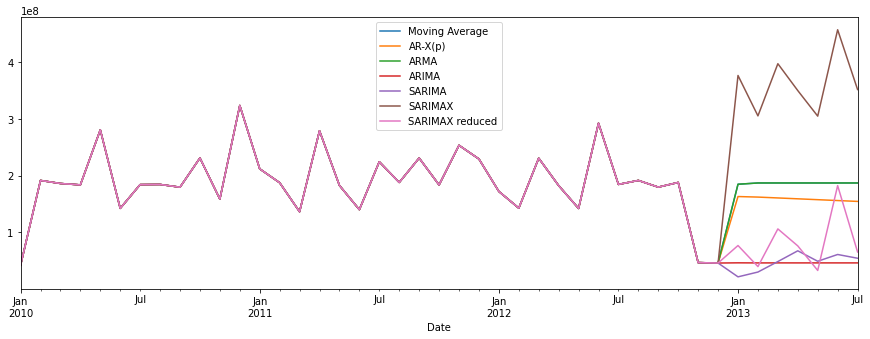

In [ ]:
df_forecast = pd.DataFrame(columns=['Date'])
df_forecast.set_index('Date', inplace=True)
df_forecast['Moving Average'] = forecast_ma
df_forecast['AR-X(p)'] = forecast_autoreg
df_forecast['ARMA'] = forecast_arma
df_forecast['ARIMA'] = forecast_arima
df_forecast['SARIMA'] = forecast_sarima
df_forecast['SARIMAX'] = forecast_sarimax
df_forecast['SARIMAX reduced'] = forecast_sarimax_reduced

for row in df_agg.itertuples():
  df_forecast.loc[row[0]] = [row[1], row[1], row[1], row[1], row[1], row[1], row[1]]

df_forecast.sort_index(inplace=True)
df_forecast.plot(figsize=(15,5));

## **Practice**

### Improve Walmart Prediction
As you can tell, there are some outliers in this data. Remove the first period and last two periods. These three datapoints are more lower than all the rest and may have had incomplete data. Run all models again. Tune them with the optimal number of AR lags, MA order, differencing integer, seasonalities, and covariates in order to see how low you can get the error scores. Then return here to see how your scores compare

In [ ]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Use this to suppress scientific notation

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/walmart_sales.csv')
df.sort_values(by=['Date'], inplace=True)
df.Date = pd.to_datetime(df.Date)
df.index = pd.DatetimeIndex(df.Date).to_period('W')
df_agg = df.groupby(pd.Grouper(freq="M")).agg({'Weekly_Sales':'sum',
                                               'Holiday_Flag':'mean',
                                               'Temperature':'mean',
                                               'Fuel_Price':'mean',
                                               'CPI':'mean',
                                               'Unemployment':'mean'})
df_agg = df_agg.iloc[1:-2]  # Remove the first row and last two rows

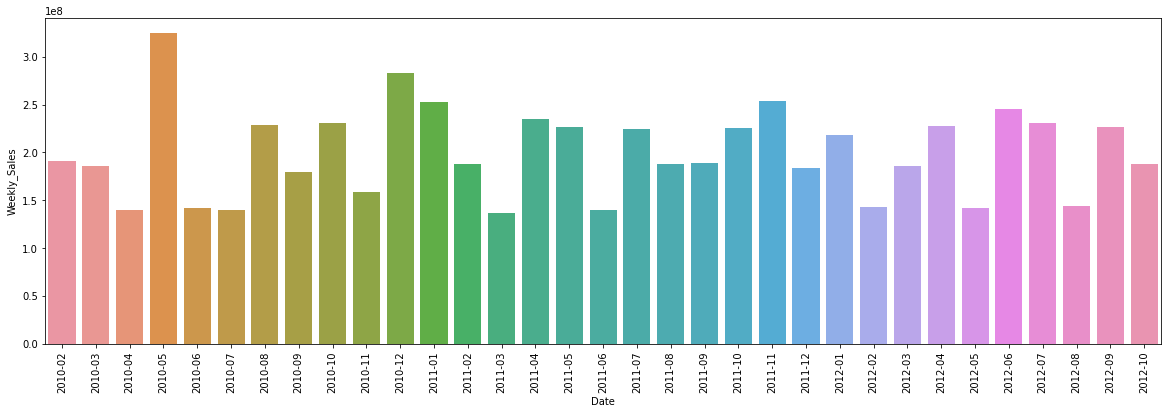

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
sns.barplot(x=df_agg.index, y="Weekly_Sales", data=df_agg, ax=ax)
plt.xticks(rotation=90)
plt.show()

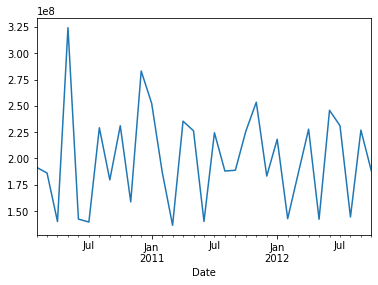

In [ ]:
df_agg.Weekly_Sales.plot();

In [ ]:
from statsmodels.tsa.stattools import adfuller

stationarity = adfuller(df_agg['Weekly_Sales'], autolag='AIC')
print("P-value: ", stationarity[1])

P-value:  0.8756666707262573


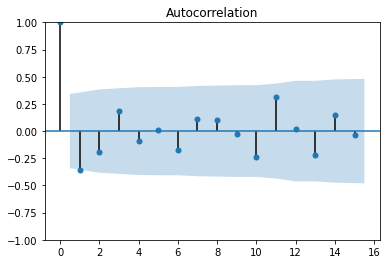

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(df_agg['Weekly_Sales'], lags=15)

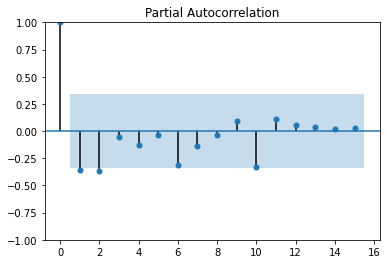

In [ ]:
pacf = plot_pacf(df_agg['Weekly_Sales'], lags=15, method='ywm')

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model_ma = ARIMA(df_agg.Weekly_Sales, order=(0, 0, 1)) # We will learn more about order= in the next algorithms
model_ma = model_ma.fit()

df_fit = pd.DataFrame(columns=['AIC', 'BIC', 'Model'])
df_fit.set_index('Model', inplace=True)

df_fit.loc["Moving Average"] = [round(model_ma.aic, 2), round(model_ma.bic, 2)]
df_fit

,AIC,BIC
Model,,
Moving Average,1254.020,1258.510


In [ ]:
from statsmodels.tsa.ar_model import AutoReg

# fit model
model_ar = AutoReg(df_agg.Weekly_Sales, lags=[1], trend='ct', seasonal=False)
model_ar = model_ar.fit()

# fit statistics to DataFrame
df_fit.loc["AutoReg"] = [round(model_ar.aic, 2), round(model_ar.bic, 2)]
df_fit

,AIC,BIC
Model,,
Moving Average,1254.020,1258.510
AutoReg,1224.190,1230.060


In [ ]:
model_arma = ARIMA(df_agg.Weekly_Sales, order=(1, 0, 1))
model_arma = model_arma.fit()

df_fit.loc["ARMA"] = [round(model_arma.aic, 2), round(model_arma.bic, 2)]
df_fit

,AIC,BIC
Model,,
Moving Average,1254.020,1258.510
AutoReg,1224.190,1230.060
ARMA,1254.820,1260.810


In [ ]:
model_arima = ARIMA(df_agg.Weekly_Sales, order=(1, 1, 1))
model_arima = model_arima.fit()

df_fit.loc["ARIMA"] = [round(model_arima.aic, 2), round(model_arima.bic, 2)]
df_fit

,AIC,BIC
Model,,
Moving Average,1254.020,1258.510
AutoReg,1224.190,1230.060
ARMA,1254.820,1260.810
ARIMA,1237.280,1241.670


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(df_agg.Weekly_Sales, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima = model_sarima.fit()

df_fit.loc["SARIMA"] = [round(model_sarima.aic, 2), round(model_sarima.bic, 2)]
df_fit

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


,AIC,BIC
Model,,
Moving Average,1254.020,1258.510
AutoReg,1224.190,1230.060
ARMA,1254.820,1260.810
ARIMA,1237.280,1241.670
SARIMA,790.670,795.650


In [ ]:
# df_exog = df_agg[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
df_exog = df_agg[['Holiday_Flag']]

model_sarimax = SARIMAX(df_agg.Weekly_Sales, exog=df_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarimax = model_sarimax.fit()

df_fit.loc["SARIMAX"] = [round(model_sarimax.aic, 2), round(model_sarimax.bic, 2)]
df_fit

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


,AIC,BIC
Model,,
Moving Average,1254.020,1258.510
AutoReg,1224.190,1230.060
ARMA,1254.820,1260.810
ARIMA,1237.280,1241.670
SARIMA,790.670,795.650
SARIMAX,791.970,797.950


### Walmart Forecast
Now that you have some new and improved models, add a 6-month forecast to the original data and .plot() it to visually compare the quality of the forecasts. Use the data below for the covariates in the SARIMAX model

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


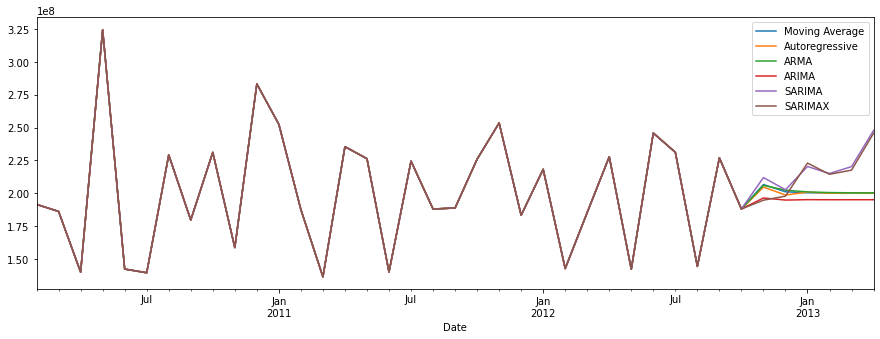

In [ ]:
exog_future = [
               [0.000],
               [0.000],
               [0.200],
               [0.000],
               [0.000],
               [0.000]
              ]

df_forecast = df_agg.copy()
df_forecast['Moving Average'] = df_agg['Weekly_Sales']
df_forecast['Autoregressive'] = df_agg['Weekly_Sales']
df_forecast['ARMA'] = df_agg['Weekly_Sales']
df_forecast['ARIMA'] = df_agg['Weekly_Sales']
df_forecast['SARIMA'] = df_agg['Weekly_Sales']
df_forecast['SARIMAX'] = df_agg['Weekly_Sales']
df_forecast.drop(columns=['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], inplace=True) # Don't need this anymore

for period in range(1, 7):
  # create the DataFrame of exogenous covariates
  df_exog = df_forecast[['Holiday_Flag']]

  # fit models
  model_ma = ARIMA(df_forecast['Moving Average'], order=(0, 0, 1)).fit()
  model_ar = AutoReg(df_forecast['Autoregressive'], lags=[1], trend='ct', seasonal=False).fit()
  model_arma = ARIMA(df_forecast['ARMA'], order=(1, 0, 1)).fit()
  model_arima = ARIMA(df_forecast['ARIMA'], order=(1, 1, 1)).fit()
  model_sarima = SARIMAX(df_forecast['SARIMA'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
  model_sarimax = SARIMAX(df_forecast['SARIMAX'], exog=df_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

  # generate the forecasts for the next period
  forecast_ma = model_ma.forecast(1)
  forecast_ar = model_ar.forecast(1)
  forecast_arma = model_arma.forecast(1)
  forecast_arima = model_arima.forecast(1)
  forecast_sarima = model_sarima.forecast(1)
  forecast_sarimax = model_sarimax.forecast(1, exog=exog_future[period - 1])

  # add forecasts to the dataframe to use in the next forecasted period
  df_forecast.loc[forecast_ma.index[0]] = [exog_future[period - 1][0],
                                           forecast_ma.iloc[0],
                                           forecast_ar.iloc[0],
                                           forecast_arma.iloc[0],
                                           forecast_arima.iloc[0],
                                           forecast_sarima.iloc[0],
                                           forecast_sarimax.iloc[0]]

df_forecast.sort_index(inplace=True)
df_forecast.drop(columns=['Holiday_Flag']).plot(figsize=(15,5));

Based on these results, it is clearly very hard to predict these sales very accurately. However, SARIMA, and SARIMAX seem to do the best job.

In [ ]:
df_forecast

,Holiday_Flag,Moving Average,Autoregressive,ARMA,ARIMA,SARIMA,SARIMAX
Date,,,,,,,
2010-02,0.000,191586880.670,191586880.670,191586880.670,191586880.670,191586880.670,191586880.670
2010-03,0.000,186226221.180,186226221.180,186226221.180,186226221.180,186226221.180,186226221.180
2010-04,0.000,140106662.760,140106662.760,140106662.760,140106662.760,140106662.760,140106662.760
2010-05,0.000,324317010.220,324317010.220,324317010.220,324317010.220,324317010.220,324317010.220
2010-06,0.000,142436081.640,142436081.640,142436081.640,142436081.640,142436081.640,142436081.640
2010-07,0.000,139635992.210,139635992.210,139635992.210,139635992.210,139635992.210,139635992.210
2010-08,0.000,229168449.420,229168449.420,229168449.420,229168449.420,229168449.420,229168449.420
2010-09,0.000,179704060.730,179704060.730,179704060.730,179704060.730,179704060.730,179704060.730
2010-10,0.200,231120142.150,231120142.150,231120142.150,231120142.150,231120142.150,231120142.150
